In [2]:
%matplotlib inline

In [3]:
# !conda list -e > requirements.txt 
# !pip freeze --local > requirements.txt
# !pip install -r requirements.txt

graph 3D ?  
plus d'ACP ?  
Choix des val de paramètre à justifier  
fast lda ?  
combiner suoervisé et non supervisé ?  
expliquer la signification des différents graph à un public non expert


<img src="img/14858512893477_so-logo.png" width="600px">    

<h1 style="font-family:verdana;font-size:300%;text-align:left;">Catégorisez automatiquement des questions</h1>

<a id="top"></a>
<h1 style="font-family:verdana;font-size:300%;text-align:left;">Sommaire</h1>

---

* [1. Sujet](#1)
    * [1.1 Contexte](#1.1)
    * [1.2 Extraction SQL](#1.2) 
* [2. Import](#2)
* [3. Cleaning -Exploration](#3)
    * [3.1 Analyse temporelle](#3.1)
    * [3.2 Distributions](#3.2)
    * [3.2 Imputation](#3.3)
* [4. Traitement du texte](#4)
    * [4.1 Text cleaning](#4.1)
    * [4.2 Tokenisation](#4.2)
    * [4.3 Mots les plus et les moins fréquents](#4.3)
* [5. Feature engeenering](#5)
* [6. Export](#6)


<a id="1"></a>
<h2 style="font-family:verdana;font-size:250%;text-align:left;">1. Sujet</h2>

---

<a id="1.1"></a>
<h3 style="font-family:verdana;font-size:200%;text-align:left;">1.1 Contexte</h3>

Stack Overflow est un site célèbre de questions-réponses liées au développement informatique.  
Pour poser une question sur ce site, il faut entrer plusieurs tags de manière à retrouver facilement la question par la suite.  
Pour les utilisateurs expérimentés, cela ne pose pas de problème, mais pour les nouveaux utilisateurs, il serait judicieux de suggérer quelques tags relatifs à la question posée.

Amateur de Stack Overflow, qui vous a souvent sauvé la mise, vous décidez d'aider la communauté en retour.  
Pour cela, vous développez un **système de suggestion de tag** pour le site.  
Celui-ci prendra la forme d’un algorithme de machine learning qui assigne automatiquement plusieurs tags pertinents à une question.

<h4 style="font-family:verdana;font-size:125%;text-align:left;">Contraintes</h4>

1. Mettre en œuvre une approche non supervisée.  
2. Utiliser une approche supervisée ou non pour extraire des tags à partir des résultats précédents.  
3. Comparer ses résultats à une approche purement supervisée, après avoir appliqué des méthodes d’extraction de features spécifiques des données textuelles.  
4. Mettre en place une méthode d’évaluation propre, avec une séparation du jeu de données pour l’évaluation.  
5. Pour suivre les modifications du code final à déployer, utiliser un logiciel de gestion de versions, par exemple Git.

<a id="1.2"></a>
<h3 style="font-family:verdana;font-size:200%;text-align:left;">1.2 Extraction SQL</h3>

La première étape consiste à récupérer un corpus grâce à un outil d’export de données.  
Celui ci prend en entrée des requêtes SQL et fourni des extractions CSV des BDD de StackOverFlow.

Voici la requête utilisée pour obtenir la BDD :


>SELECT CreationDate, Score, ViewCount, Body, Title, Tags, AnswerCount, CommentCount, FavoriteCount  
>FROM posts  
>WHERE (Tags IS NOT NULL AND Title IS NOT NULL AND Body IS NOT NULL AND FavoriteCount > 20 AND Score > 100 AND CommentCount > 0)

<a id="2"></a>
<h2 style="font-family:verdana;font-size:250%;text-align:left;">2. Import</h2>
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Sommaire</a>

---

Importons notre dataset et placons le dans un pandas dataframe.  
Nous utiliserons les dates comme index.

Options:
- Spécifier les noms des colonnes, types de variables et encodage du texte lors de l'import.

In [4]:
# Generic librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
from IPython.core.interactiveshell import InteractiveShell

# Text management librairies
from bs4 import BeautifulSoup
import re
import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
from nltk.corpus import stopwords
import contractions


# pd.set_option('display.max_column', 100)

# Activate multi output
InteractiveShell.ast_node_interactivity = "all"

# # For jupyter NB users 
# # set size of window
# display(HTML(data="""
# <style>
#     div#notebook-container    { width: 95%; }
#     div#menubar-container     { width: 65%; }
#     div#maintoolbar-container { width: 99%; }
# </style>
# """))

In [5]:
file = "data/QueryResults.csv"
data_raw = pd.read_csv(file, index_col='CreationDate', parse_dates=True)

In [6]:
data_raw.head()
data_raw.shape

,Score,ViewCount,Body,Title,Tags,AnswerCount,CommentCount,FavoriteCount
CreationDate,,,,,,,,
2010-09-27 06:56:36,152,66955,<p>I lately had the problem of creating add an...,Good or bad practice for Dialogs in wpf with M...,<c#><.net><wpf><mvvm><modal-dialog>,3,12,115
2008-08-11 08:55:13,147,253229,"<p>In C, are the shift operators (<code>&lt;&l...","Are the shift operators (<<, >>) arithmetic or...",<c><binary><bit-manipulation><bit-shift>,11,1,60
2008-08-11 10:27:22,815,576716,"<p>Whenever I design a database, I always wond...","Database, Table and Column Naming Conventions?",<database><database-design><language-agnostic>...,23,4,359
2008-08-11 11:57:17,110,238131,<p>Is this even a valid question? I have a .NE...,How do I enable MSDTC on SQL Server?,<sql-server><msdtc>,6,1,30
2008-08-10 18:41:02,539,197771,"<p>What does the expression ""Turing Complete"" ...",What is Turing Complete?,<theory><turing-machines><turing-complete>,15,1,178


(28077, 8)

Le nombre d'individus est suffisant pour pouvoir envisager une modélisation du problème grâce au machine learning.

<a id="3"></a>
<h2 style="font-family:verdana;font-size:250%;text-align:left;">3. Cleaning - Exploration</h2>

---

Explorons maintenant nos données.

In [7]:
data = data_raw.copy()

In [8]:
data.describe(include='all')

,Score,ViewCount,Body,Title,Tags,AnswerCount,CommentCount,FavoriteCount
count,28077.000000,2.807700e+04,28077,28077,28077,28077.000000,28077.000000,28077.000000
unique,NaN,NaN,28077,28077,21511,NaN,NaN,NaN
top,NaN,NaN,<p>I want to do something like this:</p>\n\n<p...,Tab key == 4 spaces and auto-indent after curl...,<git>,NaN,NaN,NaN
freq,NaN,NaN,1,1,271,NaN,NaN,NaN
mean,313.890409,2.900351e+05,NaN,NaN,NaN,12.744595,3.862913,100.568009
std,495.539472,3.780768e+05,NaN,NaN,NaN,10.265817,3.664729,191.941342
min,101.000000,2.723000e+03,NaN,NaN,NaN,0.000000,1.000000,21.000000
25%,135.000000,9.836000e+04,NaN,NaN,NaN,6.000000,1.000000,36.000000
50%,188.000000,1.824240e+05,NaN,NaN,NaN,10.000000,3.000000,56.000000
75%,313.000000,3.381630e+05,NaN,NaN,NaN,16.000000,5.000000,100.000000


Features :
* Score - Vote des utilisateurs
* ViewCount - nombre de vues
* Body - corps du post
* Title - Titre
* Tags - Tags assignés par StackOverFlow
* AnswerCount - Nombre de réponses
* CommentCount - Nombre de commentaires
* FavoriteCount - Nombre de fois mis en favoris

Constats :
* Les messages et les titres sont uniques
* Ce n'est pas le cas des Tag

<a id="3.1"></a>
<h3 style="font-family:verdana;font-size:200%;text-align:left;">3.1 Analyse temporelle</h3>

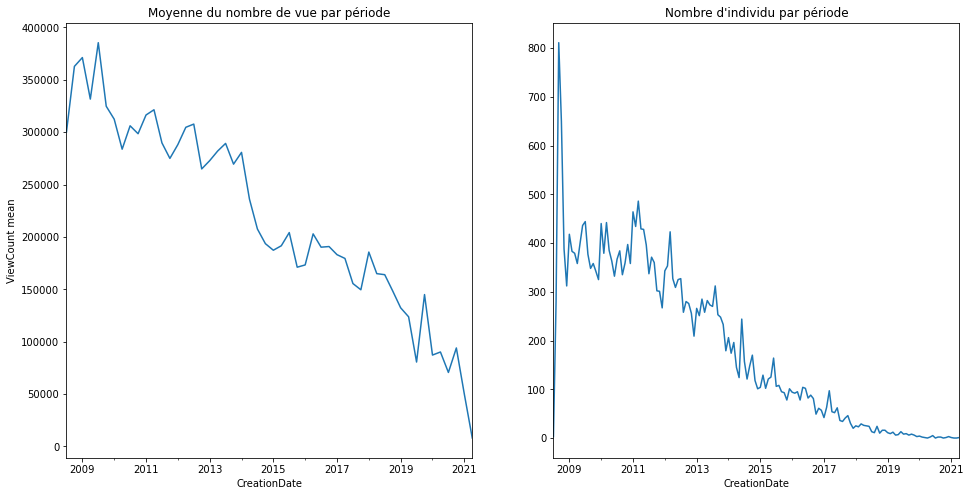

In [9]:
plt.figure(figsize=(16, 8))

plt.subplot(121)
data['ViewCount'].resample('3M').mean().plot()
plt.ylabel('ViewCount mean')
plt.title('Moyenne du nombre de vue par période')

plt.subplot(122)
data['Score'].resample('M').count().plot()
plt.title("Nombre d'individu par période")

plt.savefig('img/nb vue et individues.png', bbox_inches='tight')

plt.show();

On constate que les posts les plus anciens on en moyenne plus de vue que les récents.
De plus le nombre d'individu par période remplissant les conditions de notre requête SQL est également en diminution.

Cela peut s'expliquer par :
- Le temps que le post a été en ligne.
- La diminution du nombre de problème n'ayant pas été traité au cours du temps.

<a id="3.2"></a>
<h3 style="font-family:verdana;font-size:200%;text-align:left;">3.2 Distributions</h3>

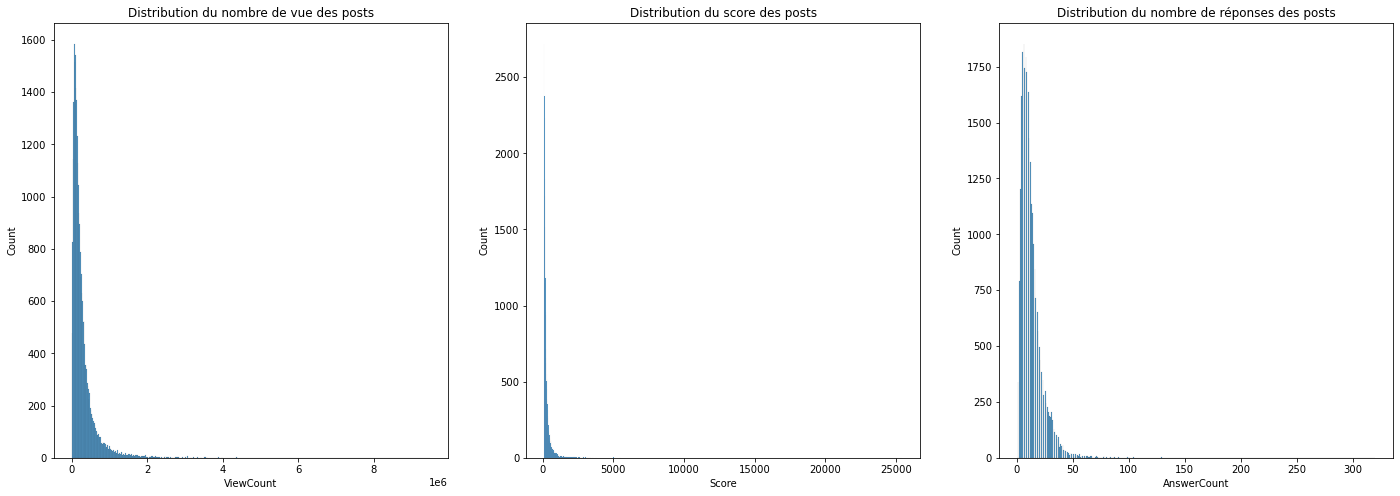

In [10]:
plt.figure(figsize=(24, 8))

plt.subplot(131)
sns.histplot(data['ViewCount'])
plt.title('Distribution du nombre de vue des posts')

plt.subplot(132)
sns.histplot(data['Score'])
plt.title('Distribution du score des posts')

plt.subplot(133)
sns.histplot(data['AnswerCount'])
plt.title('Distribution du nombre de réponses des posts')

plt.savefig('img/csv distribution.png', bbox_inches='tight')

plt.show();

Ces distributions sont très étalées sur la droite, tentons de visualiser la distribution de leur logarithme.

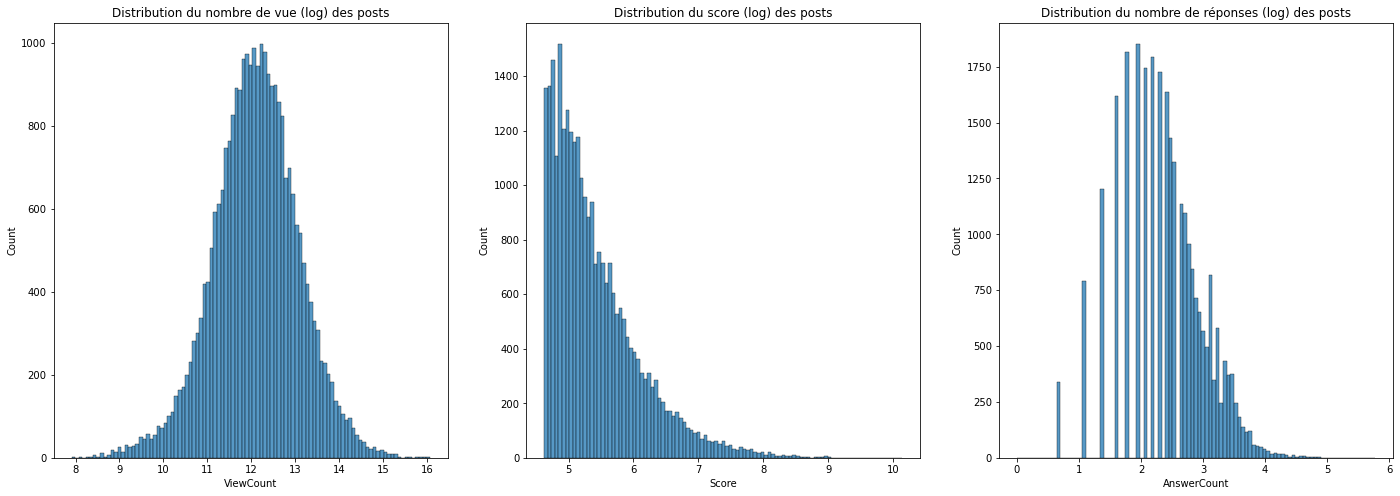

In [40]:
plt.figure(figsize=(24, 8))

plt.subplot(131)
sns.histplot(np.log1p(data['ViewCount']))
plt.title('Distribution du nombre de vue (log) des posts')

plt.subplot(132)
sns.histplot(np.log1p(data['Score']))
plt.title('Distribution du score (log) des posts')

plt.subplot(133)
sns.histplot(np.log1p(data['AnswerCount']))
plt.title('Distribution du nombre de réponses (log) des posts')

plt.savefig('img/csv distribution log.png', bbox_inches='tight')

plt.show();

Les distributions des logarithmes de ViewCount et AnswerCount semble être normales.  
Dans un exercice où les outliers perturbent notre modèle nous aurions pu les éliminer après avoir effectué une transformation log.

<a id="3.3"></a>
<h3 style="font-family:verdana;font-size:200%;text-align:left;">3.3 Imputation</h3>

In [12]:
(data.isna().sum()/data.shape[0]).sort_values()

Score            0.0
ViewCount        0.0
Body             0.0
Title            0.0
Tags             0.0
AnswerCount      0.0
CommentCount     0.0
FavoriteCount    0.0
dtype: float64

Nous constatons que le dataset est totalement renseigné.  
Il n'y a donc pas de nécessité d'imputer nos données.

<a id="4"></a>
<h2 style="font-family:verdana;font-size:250%;text-align:left;">4. Traitement du texte</h2>
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Sommaire</a>

---

Nous allons maintenant traiter les données textuelles.  
Notre but est d'obtenir des mots séparés dans une liste.

<a id="4.1"></a>
<h3 style="font-family:verdana;font-size:200%;text-align:left;">4.1 Text cleaning</h3>

Plusieurs étapes seront nécessaires, voici les premières :
1. Traitement du code html
1. Etendre les contractions
1. Traitement des caractères nuisibles (ex: /n)
1. Mettre en minuscules

Options : 
* autocorrect
* Expand contractions par dictionnaire
* Enlever ce qui est entre les balises code




In [13]:
col_txt = ['Body', 'Title']

col_w = pd.options.display.max_colwidth
pd.options.display.max_colwidth = 500 # Print more data
data.head(2)

pd.options.display.max_colwidth = col_w

,Score,ViewCount,Body,Title,Tags,AnswerCount,CommentCount,FavoriteCount
CreationDate,,,,,,,,
2010-09-27 06:56:36,152,66955,"<p>I lately had the problem of creating add and edit dialogs for my wpf app.</p>\n\n<p>All I want to do in my code was something like this. (I mostly use viewmodel first approach with mvvm)</p>\n\n<p>ViewModel which calls a dialog window:</p>\n\n<pre><code>var result = this.uiDialogService.ShowDialog(""Dialogwindow Title"", dialogwindowVM);\n// Do anything with the dialog result\n</code></pre>\n\n<p>How does it work?</p>\n\n<p>First, I created a dialog service:</p>\n\n<pre><code>public interfa...",Good or bad practice for Dialogs in wpf with MVVM?,<c#><.net><wpf><mvvm><modal-dialog>,3,12,115
2008-08-11 08:55:13,147,253229,"<p>In C, are the shift operators (<code>&lt;&lt;</code>, <code>&gt;&gt;</code>) arithmetic or logical?</p>\n","Are the shift operators (<<, >>) arithmetic or logical in C?",<c><binary><bit-manipulation><bit-shift>,11,1,60



Nous allons utiliser une librairie spécialisée pour extraire le texte de ces données : BeautifulSoup.  
Celle ci traite les balises html.  
Nous utilisons également une librairie qui enlève les contractions de mots : 'Contraction'.  
Enfin grâce à la librairie intégrée 're' nous supprimons certains caractères indésirables.

In [14]:
def cleaner(text):
    """Remove Html tags, extra spaces, ; put in lowercase"""

    text = BeautifulSoup(text, 'html.parser')
    text = text.get_text(strip=True)
    text = contractions.fix(text) # remove contractions 's => is...
    text = re.sub(r"\n", " ", text) # match all literal Line Feed (New line) pattern then replace them by a single whitespace
    text = re.sub(r'\s+', ' ', text) # match all one or more whitespace then replace them by a single whitespace
    text = text.lower()

    return text

In [15]:
for col in col_txt:
    data[col] = data[col].apply(lambda x: cleaner(x))

In [16]:
data_raw.Body[1]
data.Body[1]

'<p>In C, are the shift operators (<code>&lt;&lt;</code>, <code>&gt;&gt;</code>) arithmetic or logical?</p>\n'

'in c, are the shift operators (<<,>>) arithmetic or logical?'

Nous constatons que certains caractères non nécessaires sont toujours présents.  
Ils seront éliminés lors de la tokenisation et la sélection via regex.

<a id="4.2"></a>
<h3 style="font-family:verdana;font-size:200%;text-align:left;">4.2 Tokenization</h3>

Notre texte est maintenant nettoyé.  
La prochaine étape consiste à le tokeniser, c'est à dire le séparer en liste de mots.

Pour cela nous utilisesont une expression régulière en prenant soint de garder la lettre c seule pour le language de programmation.
De la même façon nous ajoutons '.net' donc le point n'aurais pas été pris en compte.
Nous tokeniserons aussi les tags proposés par Stackoverflow.

Option :
* Traiter le language R sans prendre en compte les faux positifs des contractions.
* Traiter les mots composés avec traits d'union

In [17]:
# only 2 caract. min words except for c for the langage and .net
tokenizer = nltk.RegexpTokenizer(r'[a-zA-Z]{2,}|c#?|.net') 

# # Take everything between the <>
# tokenizer_tags = nltk.RegexpTokenizer(r'(?<=\<).+?(?=\>)') # depreciated

In [18]:
# col_tok = [(e + '_tok') for e in col_txt] # depreciated

In [19]:
col_txt.append('Tags')

In [20]:
for coltxt in col_txt:
    data[coltxt + '_tok'] = data[coltxt].apply(lambda x: tokenizer.tokenize(x))

In [21]:
data.head()

,Score,ViewCount,Body,Title,Tags,AnswerCount,CommentCount,FavoriteCount,Body_tok,Title_tok,Tags_tok
CreationDate,,,,,,,,,,,
2010-09-27 06:56:36,152,66955,i lately had the problem of creating add and e...,good or bad practice for dialogs in wpf with m...,<c#><.net><wpf><mvvm><modal-dialog>,3,12,115,"[lately, had, the, problem, of, creating, add,...","[good, or, bad, practice, for, dialogs, in, wp...","[c#, .net, wpf, mvvm, modal, dialog]"
2008-08-11 08:55:13,147,253229,"in c, are the shift operators (<<,>>) arithmet...","are the shift operators (<<, >>) arithmetic or...",<c><binary><bit-manipulation><bit-shift>,11,1,60,"[in, c, are, the, shift, operators, arithmetic...","[are, the, shift, operators, arithmetic, or, l...","[c, binary, bit, manipulation, bit, shift]"
2008-08-11 10:27:22,815,576716,"whenever i design a database, i always wonder ...","database, table and column naming conventions?",<database><database-design><language-agnostic>...,23,4,359,"[whenever, design, database, always, wonder, i...","[database, table, and, column, naming, convent...","[database, database, design, language, agnosti..."
2008-08-11 11:57:17,110,238131,is this even a valid question? i have a .net w...,how do i enable msdtc on sql server?,<sql-server><msdtc>,6,1,30,"[is, this, even, valid, question, have, .net, ...","[how, do, enable, msdtc, on, sql, server]","[sql, server, msdtc]"
2008-08-10 18:41:02,539,197771,"what does the expression ""turing complete"" mea...",what is turing complete?,<theory><turing-machines><turing-complete>,15,1,178,"[what, does, the, expression, turing, complete...","[what, is, turing, complete]","[theory, turing, machines, turing, complete]"


<a id="4.3"></a>
<h3 style="font-family:verdana;font-size:200%;text-align:left;">4.3 Mots les plus et les moins fréquents</h3>

Nous allons maintenant enlever les mots les plus fréquents génériques de la langue.  
En effets ceux ci n'apportent pas d'information nécessaires pour notre modèle et le perturbe.

Nous allons utiliser une liste standard fournie par nltk.

En premier lieu nous allons également enlever les mots les moints fréquents, de la même manière ils n'apporteront rien au modèle et au contraire possèdent une forte cardinalité qui le ralenti.

Options :
* Ajouter les mots les plus fréquents de notre corpus à cette liste
* Enlever les adjectifs (grâce aux tag nltk)

In [22]:
col_tok = ["Body_tok", "Title_tok", "Tags_tok"]

In [23]:
def to_1D(series):
    """Transform a pd dataframe of lists in unique object with all the values"""

    return pd.Series([x for _list in series for x in _list])

# we concatenate before applying the functiun to have all the corpus
corpus_1D = to_1D(data['Title_tok'] + data['Body_tok'])
vc_corpus = corpus_1D.value_counts()
vc = vc_corpus.to_frame()

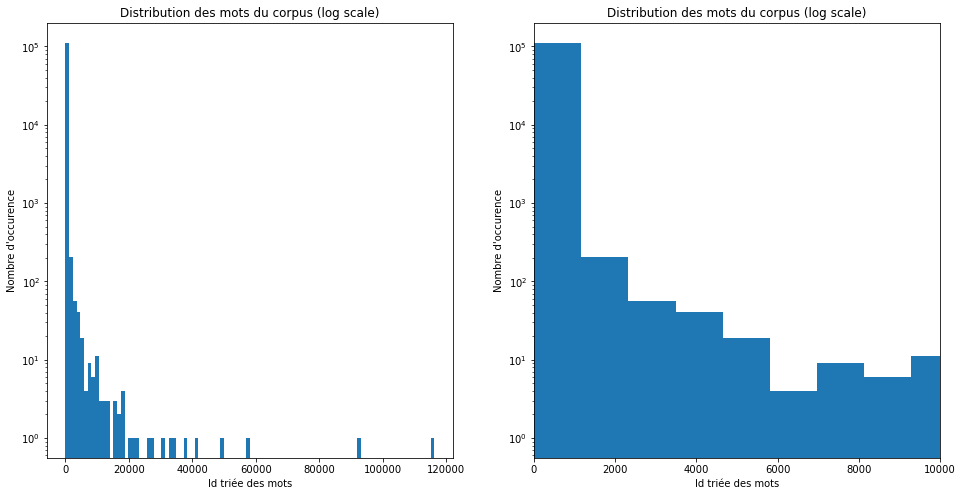

In [24]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)

plt.hist(vc, bins=100)
plt.yscale('log')
plt.title("Distribution des mots du corpus (log scale)")
plt.xlabel("Id triée des mots")
plt.ylabel("Nombre d'occurence")


plt.subplot(1, 2, 2)

plt.hist(vc, bins=100)
plt.yscale('log')
plt.title("Distribution des mots du corpus (log scale)")
plt.xlim(0, 10000)
plt.xlabel("Id triée des mots")
plt.ylabel("Nombre d'occurence")

plt.savefig('img/Corpsu distribution.png', bbox_inches='tight')

plt.show();

In [25]:
# create a list with the less frequent words
count_number = 25
lf_words = vc[vc.iloc[:,0] < count_number].index.tolist()

In [26]:
sw = stopwords.words("english")
sw.extend(lf_words)
sw = set(sw) # gain a lot of time

def remove_stopwords(list_of_words):
    """remove common words in english by using nltk.corpus's list"""
    list_of_words = [w for w in list_of_words if not w in sw]
    
    return list_of_words

In [27]:
import joblib

# saving the stop word to use in the API
joblib.dump(sw, "sw.pkl")

['sw.pkl']

In [28]:
from wordcloud import WordCloud
from PIL import Image

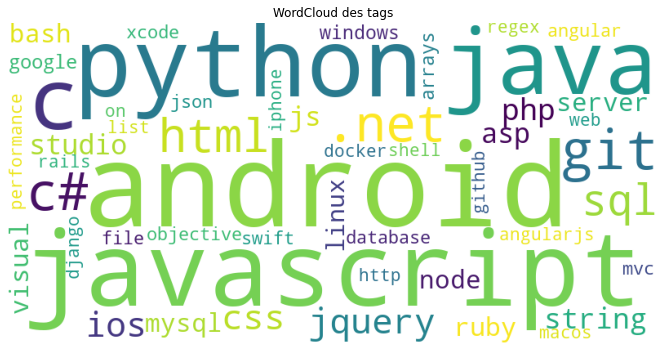

In [29]:
vc_tags = to_1D(data.Tags_tok).value_counts()

plt.figure(figsize=(12, 6))

wordcloud = WordCloud(background_color = 'white',
max_words = 50,
width=800,
height=400).generate_from_frequencies(vc_tags)
plt.imshow(wordcloud)
plt.axis("off")
plt.title("WordCloud des tags")

plt.savefig('img/wordcloud_tags.png', bbox_inches='tight')

plt.show();

In [30]:
for col in col_tok:
    data[col] = data[col].apply(lambda x: remove_stopwords(x))

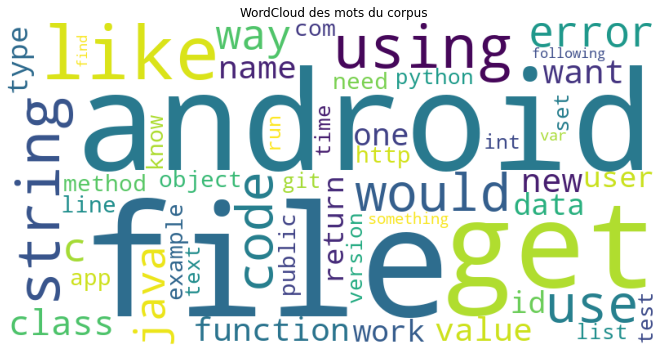

In [41]:
corpus_1D = to_1D(data['Title_tok'] + data['Body_tok'])
vc_corpus = corpus_1D.value_counts()

plt.figure(figsize=(12, 6))

wordcloud = WordCloud(background_color = 'white',
max_words = 50,
width=800,
height=400).generate_from_frequencies(vc_corpus)
plt.imshow(wordcloud)
plt.axis("off")

plt.title("WordCloud des mots du corpus")
plt.savefig('img/wordcloud_corpus.png', bbox_inches='tight')

plt.show();

<a id="4.4"></a>
<h3 style="font-family:verdana;font-size:200%;text-align:left;">4.4 Stemming / Lemmatization</h3>

**Racinisation** (ou stemming ).   
Cela consiste à ne conserver que la racine des mots étudiés. L'idée étant de supprimer les suffixes, préfixes et autres des mots afin de ne conserver que leur origine.  
C'est un procédé plus simple que la lemmatisation et plus rapide à effectuer puisqu'on tronque les mots essentiellement contrairement à la lemmatisation qui nécessite d'utiliser un dictionnaire.

Ici son usage n'est pas pertinent car nous cherchons des mots clés entiers et non leur racine.

**Lemmatisation**  
Le processus de « lemmatisation » consiste à représenter les mots (ou « lemmes ») sous leur forme canonique.   
Par exemple pour un verbe, ce sera son infinitif.
Pour un nom, son masculin singulier. 
L'idée étant encore une fois de ne conserver que le sens des mots utilisés dans le corpus.


<a id="4.4.1"></a>
<h4 style="font-family:verdana;font-size:150%;text-align:left;">4.4.1 Stemming</h3>


In [32]:
stemmer = nltk.PorterStemmer()

def stem_text(list_of_words):
    """Stem the text"""
    list_of_words = [stemmer.stem(w) for w in list_of_words] # Stem each words
    return list_of_words

In [33]:
# Example
data.Body_tok[1]
stem_text(data.Body_tok[1])

['c', 'shift', 'operators', 'arithmetic', 'logical']

['c', 'shift', 'oper', 'arithmet', 'logic']

<a id="4.4.2"></a>
<h4 style="font-family:verdana;font-size:150%;text-align:left;">4.4.2 Lemmatization</h3>

Lemmatization en utilisant la fonction WordNet intégrée à NLTK.  
Le mot reste inchangé s'il ne peut être trouvé dans WordNet.

In [34]:
lemmatizer = nltk.WordNetLemmatizer()

def lem_text(list_of_words):
    """Lemmatization of the text"""

    list_of_words = [lemmatizer.lemmatize(w) for w in list_of_words] # Lemmatize each words
    return list_of_words

In [35]:
# sample
data.Body_tok[1]
lem_text(data.Body_tok[1])

['c', 'shift', 'operators', 'arithmetic', 'logical']

['c', 'shift', 'operator', 'arithmetic', 'logical']

In [36]:
for col in col_tok:
    data[col] = data[col].apply(lambda x: lem_text(x))

<a id="5"></a>
<h2 style="font-family:verdana;font-size:250%;text-align:left;">5. Feature engineering</h2>

Nous allons maintenant rajouter une feture qui est simplement la concaténation du body et du title de chaque question.wy

In [37]:
data['Text_tok'] = data['Title_tok'] + data['Body_tok'] # adding lists
data['Text'] = data['Title'] + ' ' + data['Body'] # adding text with a space

In [38]:
# sample
data['Text'][1]

'are the shift operators (<<, >>) arithmetic or logical in c? in c, are the shift operators (<<,>>) arithmetic or logical?'

<a id="6"></a>
<h2 style="font-family:verdana;font-size:250%;text-align:left;">6. Export</h2>

Exportons le dataset afin de travailler sur un modèle dans le prochain NB.

In [39]:
data.to_csv("data\data_clean.csv")